In [80]:
import pickle
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 1.4
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 16

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [2]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

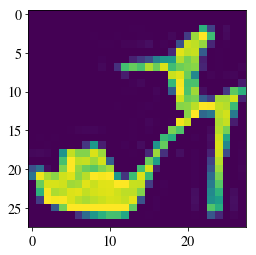

In [3]:
plt.imshow(X_train[9].reshape([28,28]))

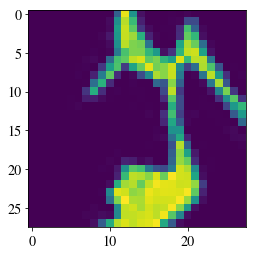

In [4]:
plt.imshow(transform.rotate(X_train[9].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [8]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [9]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [10]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

In [72]:
batch_size = 128
n_epochs = 40
nruns = 5
angle_step = 30
Ns = [500, 2000, 10000]

nscores = [] 
for N in Ns:
    scores = []
    for angle in range(0, 361, angle_step):
        tmp_score = []
        X_test_whole, y_test_whole = get_X_and_y(X_test, angle)
        for nrun in range(nruns):
            print(f'\rN={N}, angle={angle}, run={nrun+1}/{nruns}                  ',
                  end='')
            base_indices = np.random.choice(np.arange(X_train.shape[0]), 
                                            size=N, replace=False)
            base_dataset = X_train[base_indices]
            X, y = get_X_and_y(base_dataset, angle)

            # Reset weights do not work as expected
            model = keras.models.Sequential()
            model.add(keras.layers.InputLayer([784]))
            model.add(keras.layers.Dense(64))
            model.add(keras.layers.Activation('relu'))
            model.add(keras.layers.Dropout(0.5))
            model.add(keras.layers.Dense(2))
            model.add(keras.layers.Activation('softmax'))
            model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

            model.fit(X, y, batch_size=batch_size, epochs=n_epochs, verbose=0)

            y_test_predicted_whole = model.predict_classes(X_test_whole)
            tmp_score.append(accuracy_score(y_test_whole[:, 1], y_test_predicted_whole))

        scores.append([angle, np.mean(tmp_score), np.std(tmp_score)])
    nscores.append([N, scores])
    
with open('nscores.pickle', 'wb') as f:
    pickle.dump(nscores, f)

N=10000, angle=360, run=5/5                  

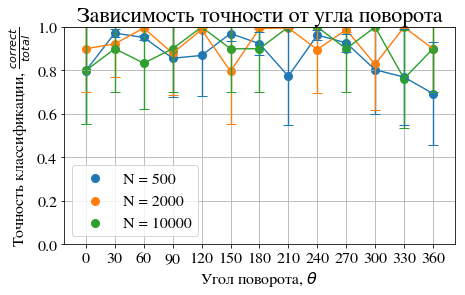

In [79]:
with open('nscores.pickle', 'rb') as f:
    nscores = pickle.load(f)

fig, ax = plt.subplots(1, 1)
ax.set_title('Зависимость точности от угла поворота')
ax.set_xlabel(r'Угол поворота, $\theta$')
ax.set_ylabel(r'Точность классификации, $\frac{correct}{total}$')

for N, scores in nscores:
    scores = np.array(scores)
    ax.scatter(scores[:, 0], scores[:, 1], label=f'N = {N}')
    ax.errorbar(scores[:, 0], scores[:, 1], yerr=scores[:, 2], 
                capsize=5, barsabove=True)
ax.set_xticks(np.arange(0, 361, 30))
ax.set_ylim(0, 1)
ax.grid()
ax.legend()
plt.show()

Зависимость от угла поворота незначительная.